In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [7]:
data_loc = "D:/Beam Characterization/2019_3_22/"
fname = "2019_03_22.h5"

In [8]:
with h5py.File(data_loc+fname, 'r') as f:
    for name in f.keys():
        print(name)

1553279965 new spot
1553280729 R1 scan 1
1553281524 new spot 2
1553281729 R1 scan 2


In [15]:
run_name = "1553281729 R1 scan 2"
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['Bristol671A'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

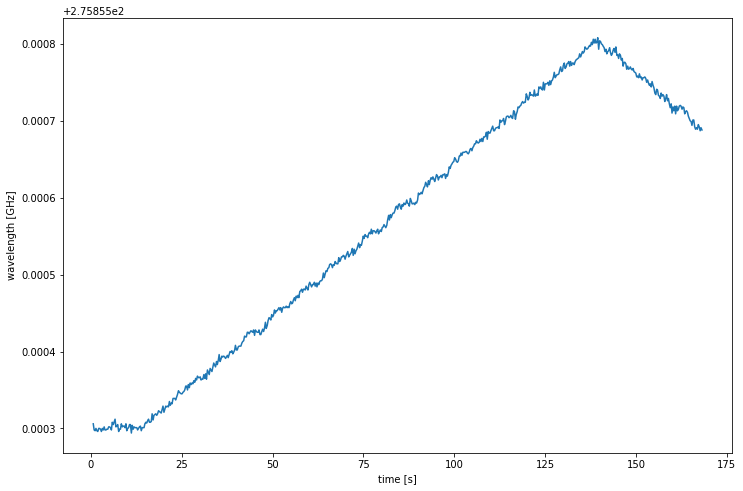

In [16]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavemeter[:,0],wavemeter[:,1])
ax.set_xlabel('time [s]')
ax.set_ylabel('wavelength [GHz]');

In [20]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

328


Text(0.5, 0, 'time [ms]')

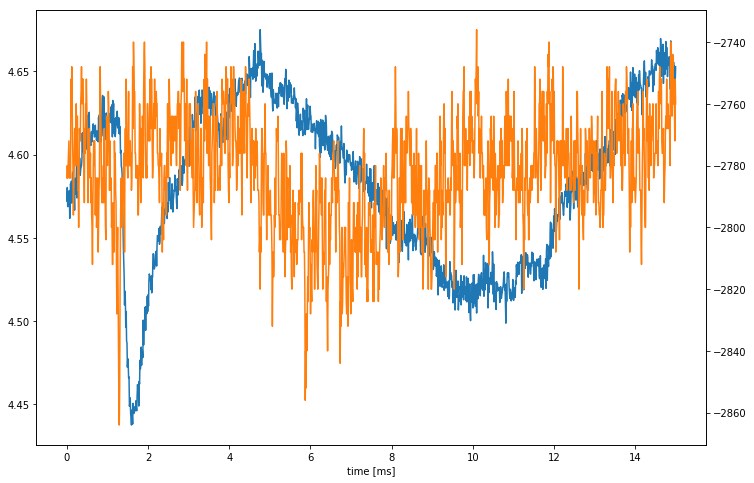

In [21]:
yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]

rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)

idx = 300
idx = yag_fire[idx]
print(idx)

x = np.linspace(0,1500,1500)/100

data_a = fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x, data_a)
ax1 = ax.twinx()
ax1.plot(x, data_f, 'C1')

ax.set_xlabel("time [ms]")

In [23]:
import datetime as dt

scan_name = '2019-3-22 R1 scan 1.lvm'

def find_nearest_value(set_val, val1, val2):
    if (np.abs(set_val - val1) > 70) & (np.abs(set_val - val2) > 70):
        return np.nan
    elif np.abs(set_val-val1) < np.abs(set_val-val2):
        return val1
    else:
        return val2

with open(data_loc+scan_name, 'r') as f:
    lines = f.read().split('\n')
    date = lines[9]
    time = lines[10]
    start_time = dt.datetime.strptime(date.split(',')[-1]+' '+time.split(',')[-1][:15], "%Y/%m/%d %H:%M:%S.%f")
    values = lines[23:-1]
    frequencies = []
    nan_counter = 0
    for val in values:
        a,b,c,d = val.split(',')
        if (float(a) == 0) or (float(a) == 1) or (float(a) == 2) or (float(a) == 3):
            continue
        if b == '':
            continue
        b = float(b)
        try:
            c = float(c)
        except ValueError:
            continue
        d = float(d)
        if np.isnan(d):
            d = 1e5
        if (len(frequencies) > 1):
            if (np.abs(frequencies[-1][1]-b) > 900):
                b += 1000
                c += 1000
                d += 1000
        t = (start_time+dt.timedelta(seconds = float(a))).timestamp()-fast_start
        nearest = find_nearest_value(b,c,d)
        
        if np.isnan(nearest):
            nan_counter += 1
            continue
        frequencies.append((t,b,nearest))
    frequencies = np.array(frequencies)
print(nan_counter)

4376


Text(0, 0.5, 'frequency relative to Cs [MHz]')

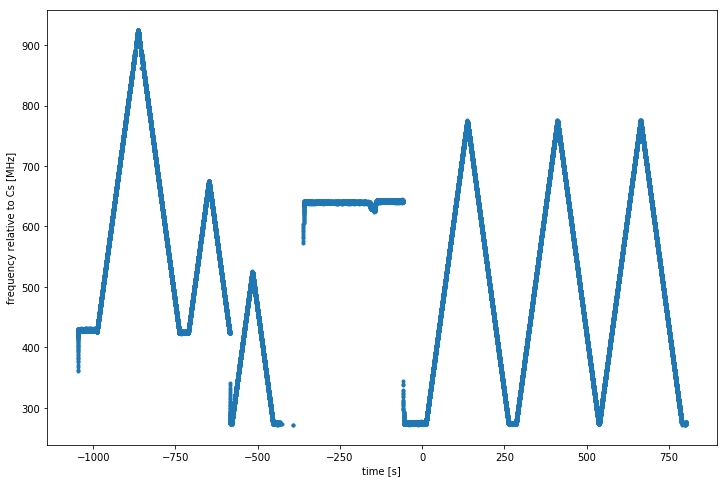

In [24]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequencies[:,0],frequencies[:,2],'.')
ax.set_xlabel('time [s]')
ax.set_ylabel('frequency relative to Cs [MHz]')

In [25]:
import tqdm
integrals = []
x = np.linspace(0,1500,1500)/100
dx = 1/1e5

for idx in tqdm.tqdm(yag_fire):
    # Check if UV is on
    if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
        data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
        background = np.trapz(data_f[:100], dx=dx)
        signal = np.trapz(data_f[200:1100], dx=dx)-9*background
        integrals.append((idx,signal*-1,background*-1))
integrals = np.array(integrals)

100%|█████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 20555.75it/s]


In [26]:
rate = 1/2
frequency_values = []
for idx in yag_fire:
    frequency_values.append((int(idx), frequencies[:,2][find_nearest_idx(frequencies[:,0], idx*rate-1.5)]))
frequency_values = np.array(frequency_values)

rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)  

In [27]:
start, stop = 0, -1

frequency_amp = []
for val in integrals[start:stop]:
    idx_int = val[0]
    frequency_amp.append((dict(frequency_values)[idx_int], val[1], idx_int))
frequency_amp = np.array(frequency_amp)
frequency_amp_wavemeter_cal = frequency_amp.copy()
frequency_amp_wavemeter_cal[:,0] += wavelength_values[0,1]*1e3-frequency_amp[0,0]

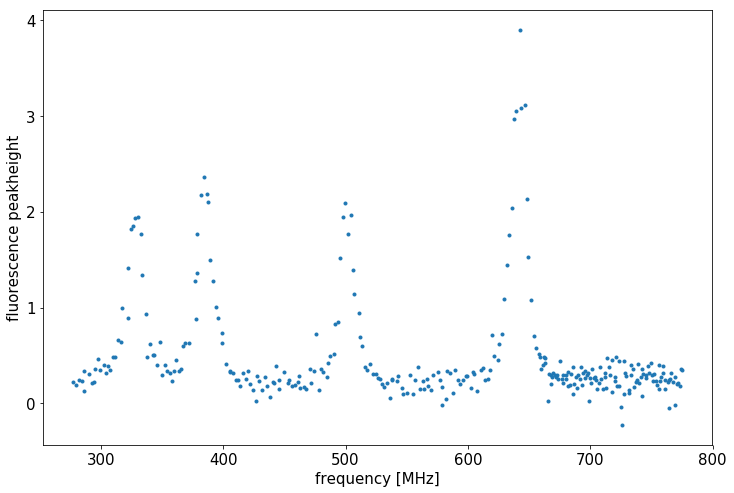

In [28]:
conversion = 1
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequency_amp[:,0]*conversion, frequency_amp[:,1], '.')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


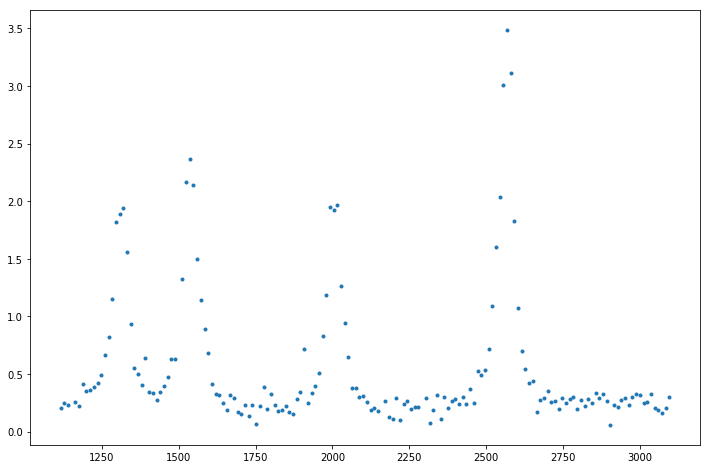

In [30]:
fit_array = frequency_amp[frequency_amp[:,0].argsort()]
fit_array[:,0] *= 4

df = 12
f_bins = np.arange(fit_array[:,0].min(), fit_array[:,0].max()+df, df)
bin_indices = np.digitize(fit_array[:,0], f_bins)
bin_means = np.array([fit_array[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
bin_errors = np.array([fit_array[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
midpoint = np.diff(f_bins)/2+f_bins[:-1]

mask_nan = ~np.isnan(bin_means)
bin_means = bin_means[mask_nan]
bin_errors = bin_errors[mask_nan]
midpoint = midpoint[mask_nan]

fig, ax = plt.subplots(figsize = (12,8))
# ax.errorbar(midpoint, bin_means, yerr = bin_errors, fmt = '.');
ax.plot(midpoint, bin_means, '.');

In [35]:
from lmfit import models
from lmfit import Model
def offset(x,offset):
    return np.ones(len(x))*offset

model_1 = models.VoigtModel(prefix='R1_1')
model_2 = models.VoigtModel(prefix='R1_2')
model_3 = models.VoigtModel(prefix='R1_3')
model_4 = models.VoigtModel(prefix='R1_4')
model_bg = Model(offset)
model = model_bg+model_1+model_2+model_3+model_4

In [45]:
s = 20
factor = 50
p0 = [(0.1),(s,1275,2*factor),(s,1550,2*factor),(s,2000,2*factor),(s,2600,5*factor)]

In [46]:
flat_params = []
for sublist in p0:
    if type(sublist) == float:
        flat_params.append(sublist)
    else:
        for item in sublist:
            flat_params.append(item)
pars = {}
for par, key in zip(flat_params, model.param_names):
    pars[key] = par 
params = model.make_params(**pars)
for par in params:
    params[par].set(min=0)
    if 'sigma' in par:
        params[par].set(max = 50)
    elif 'center' in par:
        params[par].set(min = 1000, max = 4000)

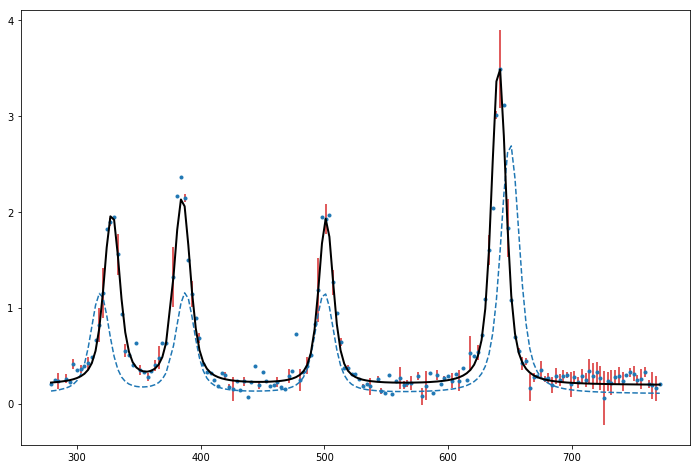

In [49]:
offset = 1
x = midpoint[:-offset]
y = bin_means[:-offset]
err = bin_errors[:-offset]
result = model.fit(y, params, x=x, weights = err)
fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(x/4,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1)
ax.plot(x/4, result.init_fit, '--')
ax.plot(x/4, result.best_fit, 'k-', lw = 2)

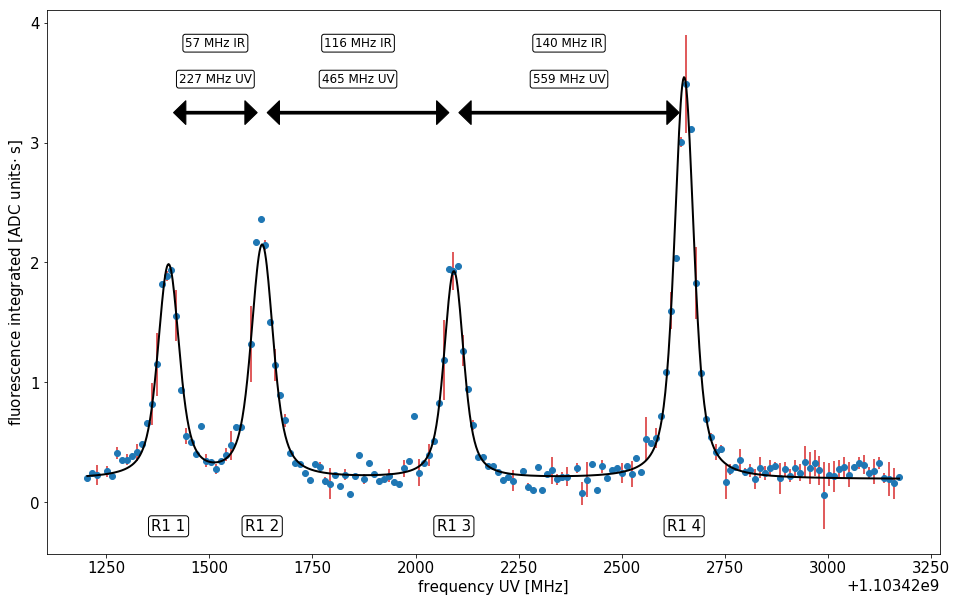

In [75]:
fit_x = np.linspace(x.min(), x.max()+1, 1001)
x_offset = frequency_amp_wavemeter_cal[0,0]*1e3*4-x[0]
plocs = []
for par in result.best_values:
    if 'center' in par:
        plocs.append(result.best_values[par])
plocs.sort()

fig, ax = plt.subplots(figsize = (16,10))
ax.errorbar(x+x_offset,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1, ms = 12)
ax.plot(fit_x+x_offset, model.eval(result.params, x=fit_x), 'k-', lw = 2)

height_arrow = 3.25
height_dist = 3.5
height_peakl = -0.2
bbox = dict(boxstyle="round", fc="w", ec="k", pad=0.2)
labels = ["R1 1", "R1 2", "R1 3", "R1 4"]
for ploc, dist, lab in zip(plocs, np.diff(plocs), labels):
    ploc += x_offset
    ax.text((ploc+dist/2),height_dist,'{0:.0f} MHz UV'.format(dist), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc+dist/2),height_dist+0.3,'{0:.0f} MHz IR'.format(dist/4), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc),height_peakl,lab, horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)

    ax.arrow((ploc+28),height_arrow,(dist-28*2.5),0, shape = 'full', head_width=0.2, head_length=30, fc='k', ec='k', width = .02)
    ax.arrow((ploc+(dist-28)),height_arrow,(-(dist-28*2.5)),0, shape = 'full', head_width=0.2, head_length=30, fc='k', ec='k', width = .02)

ax.text((plocs[-1]+x_offset),height_peakl,labels[-1], horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)
    
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency UV [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);
# fig.savefig('scanning_UV_R0toQ34.png')

In [66]:
for key in result.best_values:
    if 'center' in key:
        print("{0:15} : {1:.2f} MHz".format(key, result.best_values[key]/4))

R1_4center      : 640.92 MHz
R1_3center      : 501.27 MHz
R1_2center      : 385.01 MHz
R1_1center      : 328.22 MHz


In [74]:
for key in result.best_values:
    if 'center' in key:
        print("{0:15} : {1:.2f} MHz".format(key, result.best_values[key]/4+(frequency_amp_wavemeter_cal[0,0]*1e3-x[0]/4)))
        

R1_4center      : 275855662.91 MHz
R1_3center      : 275855523.26 MHz
R1_2center      : 275855407.00 MHz
R1_1center      : 275855350.21 MHz
